In [48]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Load data

In [49]:
df = pd.read_csv("../data/clean/main_df.csv")

In [50]:
# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})

def process_categorical(df, col):
    """
    Processes a column of *df* as categorical
    """

    def mapping(df, col):

        new_df = df.copy()

        values = new_df[col].unique()
        mapping = {value: i for i, value in enumerate(values)}
        new_df[col] = new_df[col].map(mapping)

        return new_df

    def one_hot(df, col):
        ext_df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
        ext_df.drop([col], axis=1, inplace=True)
        
        return ext_df

    return mapping(df, col)

df.fillna(-1, inplace=True)
df = process_categorical(df, "confID")
# df = process_categorical(df, "tmID")
# map_strings_to_int(df, "playerID")
# map_strings_to_int(df, "coachID")
# map_strings_to_int(df, "pos")

df.to_csv("../data/clean/pre.csv", index=False)

# print(df['tmID'].to_frame())

### Turn string values into numerical ones

### Training and evaluation function

In [51]:
from dataclasses import dataclass
from collections import defaultdict

@dataclass
class Result:
    year: int
    accuracy: float
    auc: float

results = defaultdict(list)

def classification(model, df, min_year, max_year, param_list):

    def cv(df, min_year, max_year):
        for i in range(min_year, max_year + 1):
            df_train = df[(df['year'] < i) & (df['year'] > 1)]
            df_test = df[df['year'] == i]

            X_train = df_train.drop("playoff", axis=1)  # Features
            y_train = df_train["playoff"]  # Target variable

            X_test = df_test.drop("playoff", axis=1)  # Features
            y_test = df_test["playoff"]  # Target variable


    def score(model, df, min_year, max_year):
        results = []

        for i in range(min_year, max_year + 1):
            df_train = df[(df['year'] < i) & (df['year'] > 1)]
            df_test = df[df['year'] == i]

            X_train = df_train.drop(["playoff", "year", "tmID"], axis=1)  # Features
            y_train = df_train["playoff"]  # Target variable

            X_test = df_test.drop(["playoff", "year", "tmID"], axis=1)  # Features
            y_test = df_test["playoff"]  # Target variable

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            results.append(accuracy_score(y_test, y_pred))

        return sum(result * (i + 1) for result, i in enumerate(results)) / sum(range(len(results) + 1))

    def param_tuning(model, df, min_year, max_year, param_list):
        grid = HalvingRandomSearchCV(
            model,
            param_distributions=param_list,
            cv=5,
            min_resources='smallest',
            factor=2,
            n_jobs=16,
            random_state=42,
            # scoring=lambda model, X, y: score(model, df, min_year, max_year),
        )
        grid.fit(df.drop(["playoff", "year", "tmID"], axis=1), df["playoff"])

        return grid.best_estimator_

    def test_model(model, df, params):
        pass

    model = param_tuning(model, df, min_year, max_year, param_list)

    for i in range(min_year, max_year + 1):
        df_train = df[(df['year'] < i) & (df['year'] > 1)]
        df_test = df[df['year'] == i]

        df_train.drop(["year", "tmID"], axis=1, inplace=True)
        df_test.drop(["year", "tmID"], axis=1, inplace=True)

        X_train = df_train.drop("playoff", axis=1)  # Features
        y_train = df_train["playoff"]  # Target variable

        X_test = df_test.drop("playoff", axis=1)  # Features
        y_test = df_test["playoff"]  # Target variable

        print(f"\nTrain/Test size for year={i}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        model.fit(X_train, y_train)

        # Predict the response for the test dataset
        y_pred = model.predict(X_test)

        print(f"\nyear = {i}, Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
        print(f"\nyear = {i}, Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(f"\nyear = {i}, AUC: ", roc_auc_score(y_test, y_pred))
        print(f"\nyear = {i}, Accuracy: ", accuracy_score(y_test, y_pred))

        result = Result(
            year=i,
            accuracy=accuracy_score(y_test, y_pred),
            auc=roc_auc_score(y_test, y_pred),
        )

        results[model].append(result)

    return model

### Define values for min_year and max_year

In [52]:
min_year = 3
max_year = df['year'].max()

### Decision Tree

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/15


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       1.00      0.25      0.40         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16


year = 3, Confusion Matrix:
 [[8 0]
 [6 2]]

year = 3, AUC:  0.625

year = 3, Accuracy:  0.625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.56      0.62      0.59         8

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14


year = 4, Confusion Matrix:
 [[2 4]
 [3 5]]

year = 4, AUC:  0.47

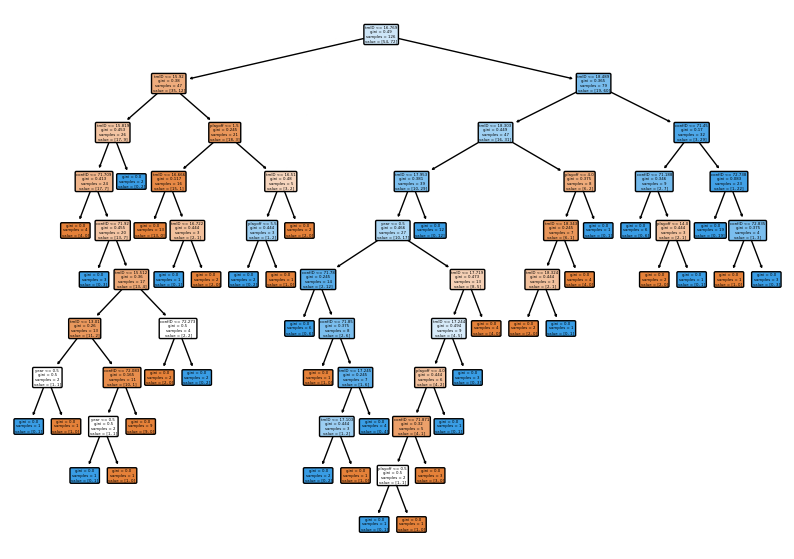

In [53]:
model = DecisionTreeClassifier(random_state=42)
model = classification(model, df, min_year, max_year, param_list={
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(2, 20),
})

from sklearn.tree import plot_tree

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plot_tree(model, filled=True, feature_names=df.columns.to_list(), rounded=True)
plt.show()

### SVM

In [54]:
model = SVC(random_state=42)
classification(model, df, min_year, max_year, param_list={
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': range(1, 10),
    'gamma': ['scale', 'auto'],
    'C': range(1, 10),
})

KeyboardInterrupt: 

### Logistic Regression

In [55]:
model = LogisticRegression(random_state=42)
classification(model, df, min_year, max_year, param_list={
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': range(1, 10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [1000],
})

/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not c


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.67      0.75      0.71         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16


year = 3, Confusion Matrix:
 [[5 3]
 [2 6]]

year = 3, AUC:  0.6875

year = 3, Accuracy:  0.6875

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.70      0.88      0.78         8

    accuracy                           0.71        14
   macro avg       0.72      0.69      0.69        14
weighted avg       0.72      0.71      0.70        14


year = 4, Confusion Matrix:
 [[3 3]
 [1 7]]

year = 4, AUC:  0.

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting p

LogisticRegression(C=4, max_iter=1000, penalty='none', random_state=42,
                   solver='sag')

### Random Forest

In [56]:
model = RandomForestClassifier(random_state=42)
classification(model, df, min_year, max_year, {
    'n_estimators': range(1, 10),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
})


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.56      0.62      0.59         8

    accuracy                           0.56        16
   macro avg       0.56      0.56      0.56        16
weighted avg       0.56      0.56      0.56        16


year = 3, Confusion Matrix:
 [[4 4]
 [3 5]]

year = 3, AUC:  0.5625

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.67      0.75      0.71         8

    accuracy                           0.64        14
   macro avg       0.63      0.62      0.63        14
weighted avg       0.64      0.64      0.64        14


year = 4, Confusion Matrix:
 [[3 3]
 [2 6]]

year = 4, AUC:  0.

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/15

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=5,
                       random_state=42)

### Gradient Boosting Classifier

In [57]:
model = GradientBoostingClassifier()
classification(model, df, min_year, max_year, {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.1, 0.5, 1],
    'n_estimators': range(1, 10),
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': range(1, 10),
})


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73         8
           1       1.00      0.25      0.40         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16


year = 3, Confusion Matrix:
 [[8 0]
 [6 2]]

year = 3, AUC:  0.625

year = 3, Accuracy:  0.625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.50      0.62      0.56         8

    accuracy                           0.43        14
   macro avg       0.38      0.40      0.38        14
weighted avg       0.39      0.43      0.40        14


year = 4, Confusion Matrix:
 [[1 5]
 [3 5]]

year = 4, AUC:  0.39

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/15

GradientBoostingClassifier(learning_rate=0.5, loss='exponential', max_depth=4,
                           n_estimators=1)

### K Neighbors

In [58]:
model = KNeighborsClassifier()
classification(model, df, min_year, max_year, param_list={
    'n_neighbors': range(1, 10),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(1, 10),
    'p': [1, 2],
})

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/15


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.80      0.50      0.62         8

    accuracy                           0.69        16
   macro avg       0.72      0.69      0.68        16
weighted avg       0.72      0.69      0.68        16


year = 3, Confusion Matrix:
 [[7 1]
 [4 4]]

year = 3, AUC:  0.6875

year = 3, Accuracy:  0.6875

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.75      0.75      0.75         8

    accuracy                           0.71        14
   macro avg       0.71      0.71      0.71        14
weighted avg       0.71      0.71      0.71        14


year = 4, Confusion Matrix:
 [[4 2]
 [2 6]]

year = 4, AUC:  0.

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/15


year = 7, Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.88      0.88      0.88         8

    accuracy                           0.86        14
   macro avg       0.85      0.85      0.85        14
weighted avg       0.86      0.86      0.86        14


year = 7, Confusion Matrix:
 [[5 1]
 [1 7]]

year = 7, AUC:  0.8541666666666666

year = 7, Accuracy:  0.8571428571428571

Train/Test size for year=8: (86, 4) (13, 4) (86,) (13,)

year = 8, Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13


year = 8, Confusion Matrix:
 [[2 3]
 [1 7]]

year = 8, AUC:  0.6375

year = 8, Accuracy:  0.6923

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/15

KNeighborsClassifier(algorithm='brute', leaf_size=9, n_neighbors=9)

### Neural networks

In [59]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(random_state=42)),
])
classification(model, df, min_year, max_year, param_list={
    'model__hidden_layer_sizes': [(50, 25)],  
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],  
    'model__solver': ['adam'],
    'model__max_iter': [1000],
    'model__learning_rate': ['constant', 'adaptive', 'invscaling']
})


/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/toino/.local/lib/python3.11/site-packages/


Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)


/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)



year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.38      0.46         8
           1       0.55      0.75      0.63         8

    accuracy                           0.56        16
   macro avg       0.57      0.56      0.55        16
weighted avg       0.57      0.56      0.55        16


year = 3, Confusion Matrix:
 [[3 5]
 [2 6]]

year = 3, AUC:  0.5625

year = 3, Accuracy:  0.5625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.50      0.62      0.56         8

    accuracy                           0.43        14
   macro avg       0.38      0.40      0.38        14
weighted avg       0.39      0.43      0.40        14


year = 4, Confusion Matrix:
 [[1 5]
 [3 5]]

year = 4, AUC:  0.3958333333333333

year = 4, Accuracy:  0.4285714285714285

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)



year = 5, Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.56      0.62      0.59         8

    accuracy                           0.46        13
   macro avg       0.40      0.41      0.41        13
weighted avg       0.44      0.46      0.45        13


year = 5, Confusion Matrix:
 [[1 4]
 [3 5]]

year = 5, AUC:  0.4125

year = 5, Accuracy:  0.46153846153846156

Train/Test size for year=6: (59, 4) (13, 4) (59,) (13,)


/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)



year = 6, Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.88      0.88      0.88         8

    accuracy                           0.85        13
   macro avg       0.84      0.84      0.84        13
weighted avg       0.85      0.85      0.85        13


year = 6, Confusion Matrix:
 [[4 1]
 [1 7]]

year = 6, AUC:  0.8375

year = 6, Accuracy:  0.8461538461538461

Train/Test size for year=7: (72, 4) (14, 4) (72,) (14,)


/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic


year = 7, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.60      0.75      0.67         8

    accuracy                           0.57        14
   macro avg       0.55      0.54      0.53        14
weighted avg       0.56      0.57      0.55        14


year = 7, Confusion Matrix:
 [[2 4]
 [2 6]]

year = 7, AUC:  0.5416666666666667

year = 7, Accuracy:  0.5714285714285714

Train/Test size for year=8: (86, 4) (13, 4) (86,) (13,)


/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)



year = 8, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.64      0.88      0.74         8

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13


year = 8, Confusion Matrix:
 [[1 4]
 [1 7]]

year = 8, AUC:  0.5375

year = 8, Accuracy:  0.6153846153846154

Train/Test size for year=9: (99, 4) (14, 4) (99,) (14,)


/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)



year = 9, Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.57      0.50      0.53         8

    accuracy                           0.50        14
   macro avg       0.50      0.50      0.50        14
weighted avg       0.51      0.50      0.50        14


year = 9, Confusion Matrix:
 [[3 3]
 [4 4]]

year = 9, AUC:  0.5

year = 9, Accuracy:  0.5

Train/Test size for year=10: (113, 4) (13, 4) (113,) (13,)


/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)



year = 10, Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.78      0.88      0.82         8

    accuracy                           0.77        13
   macro avg       0.76      0.74      0.75        13
weighted avg       0.77      0.77      0.76        13


year = 10, Confusion Matrix:
 [[3 2]
 [1 7]]

year = 10, AUC:  0.7375

year = 10, Accuracy:  0.7692307692307693

Train/Test size for year=11: (126, 4) (12, 4) (126,) (12,)

year = 11, Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.75      0.75      0.75         8

    accuracy                           0.67        12
   macro avg       0.62      0.62      0.62        12
weighted avg       0.67      0.67      0.67        12


year = 11, Confusion Matrix:
 [[2 2]
 [2 6]]

year = 11, AUC:  0.625

year = 11, Accuracy:  0.666666

/home/toino/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 MLPClassifier(hidden_layer_sizes=(50, 25),
                               learning_rate='adaptive', max_iter=1000,
                               random_state=42))])

### AdaBoost Classifier

In [60]:
model = AdaBoostClassifier(random_state=42)
classification(model, df, min_year, max_year, param_list={
    'n_estimators': range(1, 10),
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
})



Train/Test size for year=3: (16, 4) (16, 4) (16,) (16,)

year = 3, Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.62      0.62      0.62         8

    accuracy                           0.62        16
   macro avg       0.62      0.62      0.62        16
weighted avg       0.62      0.62      0.62        16


year = 3, Confusion Matrix:
 [[5 3]
 [3 5]]

year = 3, AUC:  0.625

year = 3, Accuracy:  0.625

Train/Test size for year=4: (32, 4) (14, 4) (32,) (14,)

year = 4, Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.33      0.36         6
           1       0.56      0.62      0.59         8

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14


year = 4, Confusion Matrix:
 [[2 4]
 [3 5]]

year = 4, AUC:  0.47

/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/1556071308.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(["year", "tmID"], axis=1, inplace=True)
/tmp/ipykernel_19207/15

AdaBoostClassifier(learning_rate=0.5, n_estimators=9, random_state=42)

# Results

In [61]:
for model in results:
    for result in results[model]:
        if result.accuracy == 1:
            print(f"\n{model} has 100% accuracy for year {result.year}, possible data leakage")

results_df = pd.DataFrame(
    data=[[
        model, result[-1].accuracy, 
        result[-2].accuracy, 
        sum(r.accuracy for r in result[:-1]) / (len(result) - 1),
    ] for model, result in results.items()],
    columns=[
        "model", "last year accuracy", "second to last year accuracy", "average accuracy",
    ],
)

results_df.sort_values(by=["last year accuracy", "second to last year accuracy", "average accuracy",], ascending=False)


,model,last year accuracy,second to last year accuracy,average accuracy
4,"KNeighborsClassifier(algorithm='brute', leaf_s...",0.833333,0.692308,0.728108
1,"LogisticRegression(C=4, max_iter=1000, penalty...",0.833333,0.692308,0.691020
2,"(DecisionTreeClassifier(criterion='entropy', m...",0.750000,0.769231,0.667153
6,"(DecisionTreeClassifier(max_depth=1, random_st...",0.750000,0.769231,0.648180
5,"(StandardScaler(), MLPClassifier(hidden_layer_...",0.666667,0.769231,0.594351
3,([DecisionTreeRegressor(criterion='friedman_ms...,0.583333,0.615385,0.584306
0,"DecisionTreeClassifier(max_depth=16, random_st...",0.416667,0.615385,0.610405


## Predictions

In [72]:
best_model = max(results, key=lambda model: sum(r.accuracy for r in results[model]))

last_year = df[df["year"] == df["year"].max()]

X = last_year.drop(["playoff", "year", "tmID"], axis=1)  # Features
y = best_model.predict(X)

predictions_df = pd.DataFrame(
    data={
        "tmID": last_year["tmID"],
        "playoff": y,
    }
)

predictions_df


,tmID,playoff
2,ATL,1
14,CHI,0
26,CON,0
56,IND,1
67,LAS,1
81,MIN,1
92,NYL,1
106,PHO,1
127,SAS,1
138,SEA,1
